<a href="https://colab.research.google.com/github/hongwon2/HG-MLDL/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D2_%EA%B0%80%EC%A7%9C_%EB%89%B4%EC%8A%A4_%EB%B6%84%EB%A5%98_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 메소드

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
!pip install contractions
import contractions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, \
                             recall_score, f1_score, roc_curve, \
                             accuracy_score, roc_auc_score
from sklearn.model_selection import ParameterGrid, GridSearchCV


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.layers import  Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

from __future__ import absolute_import, division, print_function, unicode_literals

VOCAB_SIZE = 5000

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 5.0 MB/s 
     |████████████████████████████████| 287 kB 39.5 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
  path = '/content/drive/MyDrive/kaggle_data/'
  test   = pd.read_csv(path + 'test.csv'  )
  train  = pd.read_csv(path + 'train.csv' )
  submit = pd.read_csv(path + 'submit.csv')

# 데이터 전처리

In [4]:
def data_clean(dt):
  dt = dt.fillna('')
  dt["total"] = dt['title'] + " " + dt["author"]  
  return dt

In [5]:
def text_cleaning(df):
    ps = PorterStemmer()
    corpus = []
    for i in range(len(df)):
        m = re.sub("[^a-zA-Z]", " ", df["total"][i])
        m = m.lower()
        m = m.split()
        m = [ps.stem(word) for word in m if not word in stopwords.words('english')]
        clean_text = " ".join(m)
        corpus.append(clean_text)
    return corpus

In [6]:
def onehot(corpus, VOCAB_SIZE = 5000):
  return [one_hot(words, VOCAB_SIZE) for words in corpus]

In [7]:
def padding(onehot_text) :
  return np.array(pad_sequences(onehot_text, padding="pre", maxlen = 25))

In [8]:
def get_label(df):
  return np.array(df["label"])

In [9]:
def make_clean(df) :
  corpus = data_clean(df)
  corpus = text_cleaning(corpus)
  corpus = onehot(corpus)
  corpus = padding(corpus)
  return   corpus

In [10]:
def get_data() :
  path = '/content/drive/MyDrive/kaggle_data/'
  test   = pd.read_csv(path + 'test.csv'  )
  train  = pd.read_csv(path + 'train.csv' )
  submit = pd.read_csv(path + 'submit.csv')

  x = np.array(list(make_clean(train)) + list(make_clean(test )))
  y = np.array(list(get_label(train )) + list(get_label(submit)))
  return train_test_split(x, y, test_size = 0.1, random_state = 1234)

In [11]:
def save_data(path, train_x, test_x, train_y, test_y) :
  np.save(path + 'train_x', train_x)
  np.save(path + 'test_x' , test_x )
  np.save(path + 'train_y', train_x)
  np.save(path + 'test_y' , test_x )

In [12]:
train_x, test_x, train_y, test_y = get_data()

save_data(path, train_x, test_x, train_y, test_y)

In [13]:
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size = 0.1,random_state = 1234)

In [14]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(21060, 25)
(21060,)
(2340, 25)
(2340,)
(2600, 25)
(2600,)


#모델링

## RNN

In [17]:
model_RNN = Sequential()
model_RNN.add(Embedding(30000, 30))
model_RNN.add(SimpleRNN(100))
model_RNN.add(Dense(1, activation='sigmoid'))
model_RNN.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['acc'])
history_RNN = model_RNN.fit(train_x, train_y, epochs=100,
                    validation_data=(val_x, val_y))
model_RNN.summary()

Epoch 1/100
659/659 [==============================] - 16s 22ms/step - loss: 0.3197 - acc: 0.8834 - val_loss: 0.2581 - val_acc: 0.9192
Epoch 2/100
659/659 [==============================] - 13s 19ms/step - loss: 0.2100 - acc: 0.9266 - val_loss: 0.2732 - val_acc: 0.9115
Epoch 3/100
659/659 [==============================] - 13s 19ms/step - loss: 0.1239 - acc: 0.9573 - val_loss: 0.3143 - val_acc: 0.8970
Epoch 4/100
659/659 [==============================] - 13s 19ms/step - loss: 0.0651 - acc: 0.9791 - val_loss: 0.4171 - val_acc: 0.8876
Epoch 5/100
659/659 [==============================] - 14s 21ms/step - loss: 0.0452 - acc: 0.9861 - val_loss: 0.4446 - val_acc: 0.8859
Epoch 6/100
659/659 [==============================] - 13s 19ms/step - loss: 0.0361 - acc: 0.9896 - val_loss: 0.5133 - val_acc: 0.8829
Epoch 7/100
659/659 [==============================] - 13s 19ms/step - loss: 0.0345 - acc: 0.9890 - val_loss: 0.5469 - val_acc: 0.8812
Epoch 8/100
659/659 [==============================] - 

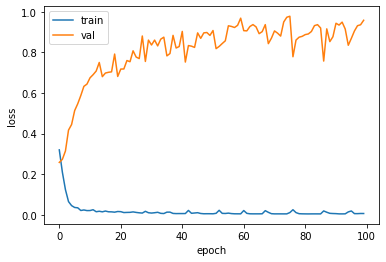

In [18]:
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [19]:
model_RNN.evaluate(val_x, val_y)

74/74 [==============================] - 0s 4ms/step - loss: 0.9581 - acc: 0.8607


[0.958089292049408, 0.8606837391853333]

## LSTM

In [20]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(30000, 30))
model_LSTM.add(keras.layers.Dropout(0.3))
model_LSTM.add(LSTM(100))
model_LSTM.add(keras.layers.Dropout(0.3))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(keras.layers.Dropout(0.3))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['acc'])
history_LSTM = model_LSTM.fit(train_x, train_y, epochs=100,
                    validation_data=(val_x, val_y))
model_LSTM.summary()

Epoch 1/100
659/659 [==============================] - 26s 36ms/step - loss: 0.3222 - acc: 0.8853 - val_loss: 0.2585 - val_acc: 0.9179
Epoch 2/100
659/659 [==============================] - 27s 40ms/step - loss: 0.2448 - acc: 0.9208 - val_loss: 0.2588 - val_acc: 0.9150
Epoch 3/100
659/659 [==============================] - 24s 37ms/step - loss: 0.2250 - acc: 0.9246 - val_loss: 0.2698 - val_acc: 0.9120
Epoch 4/100
659/659 [==============================] - 23s 34ms/step - loss: 0.2051 - acc: 0.9282 - val_loss: 0.2910 - val_acc: 0.9047
Epoch 5/100
659/659 [==============================] - 23s 34ms/step - loss: 0.1825 - acc: 0.9328 - val_loss: 0.3020 - val_acc: 0.9004
Epoch 6/100
659/659 [==============================] - 23s 34ms/step - loss: 0.1624 - acc: 0.9377 - val_loss: 0.3585 - val_acc: 0.8927
Epoch 7/100
659/659 [==============================] - 23s 34ms/step - loss: 0.1447 - acc: 0.9440 - val_loss: 0.3733 - val_acc: 0.8850
Epoch 8/100
659/659 [==============================] - 

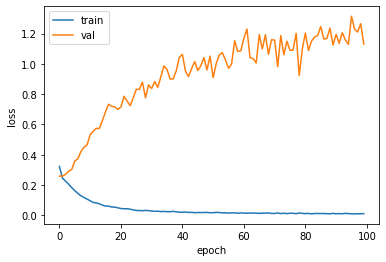

In [21]:
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [22]:
model_LSTM.evaluate(val_x, val_y)

74/74 [==============================] - 1s 8ms/step - loss: 1.1307 - acc: 0.8910


[1.130738615989685, 0.8910256624221802]

## GRU

In [23]:
model_GRU = Sequential()
model_GRU.add(Embedding(30000, 64))
model_GRU.add(keras.layers.Dropout(0.3))
model_GRU.add(GRU(64))
model_GRU.add(keras.layers.Dropout(0.3))
model_GRU.add(Dense(16, activation='relu'))
model_GRU.add(keras.layers.Dropout(0.3))
model_GRU.add(Dense(1, activation='sigmoid'))
model_GRU.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['acc'])

history_GRU = model_GRU.fit(train_x, train_y, epochs=100,
                    validation_data=(val_x, val_y))
model_GRU.summary()

Epoch 1/100
659/659 [==============================] - 29s 40ms/step - loss: 0.3251 - acc: 0.8892 - val_loss: 0.2591 - val_acc: 0.9132
Epoch 2/100
659/659 [==============================] - 26s 39ms/step - loss: 0.2501 - acc: 0.9206 - val_loss: 0.2586 - val_acc: 0.9132
Epoch 3/100
659/659 [==============================] - 25s 39ms/step - loss: 0.2230 - acc: 0.9255 - val_loss: 0.2710 - val_acc: 0.9128
Epoch 4/100
659/659 [==============================] - 25s 38ms/step - loss: 0.2034 - acc: 0.9297 - val_loss: 0.2984 - val_acc: 0.9030
Epoch 5/100
659/659 [==============================] - 27s 41ms/step - loss: 0.1819 - acc: 0.9347 - val_loss: 0.3674 - val_acc: 0.8979
Epoch 6/100
659/659 [==============================] - 25s 39ms/step - loss: 0.1595 - acc: 0.9370 - val_loss: 0.3725 - val_acc: 0.8940
Epoch 7/100
659/659 [==============================] - 25s 39ms/step - loss: 0.1426 - acc: 0.9413 - val_loss: 0.3841 - val_acc: 0.8966
Epoch 8/100
659/659 [==============================] - 

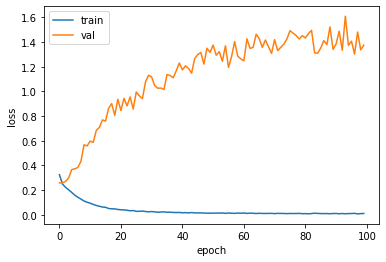

In [24]:
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [25]:
model_GRU.evaluate(val_x, val_y)

74/74 [==============================] - 0s 6ms/step - loss: 1.3751 - acc: 0.8744


[1.3751423358917236, 0.8743589520454407]

## CNN-LSTM


In [26]:
train_x.shape

(21060, 25)

In [27]:
model_CNN_LSTM = Sequential()
model_CNN_LSTM.add(keras.layers.Embedding(30000, 30))
model_CNN_LSTM.add(keras.layers.Dropout(0.3))
model_CNN_LSTM.add(keras.layers.Conv1D(32, 3, padding='same', strides=1,activation='relu'))
model_CNN_LSTM.add(keras.layers.MaxPooling1D(2))
model_CNN_LSTM.add(LSTM(100))
model_CNN_LSTM.add(keras.layers.Dropout(0.3))
model_CNN_LSTM.add(Dense(1, activation='sigmoid'))
model_CNN_LSTM.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['acc'])
history_CNN_LSTM = model_CNN_LSTM.fit(train_x, train_y, epochs=100,
                    validation_data=(val_x, val_y))
model_CNN_LSTM.summary()



Epoch 1/100
659/659 [==============================] - 20s 27ms/step - loss: 0.3350 - acc: 0.8705 - val_loss: 0.2563 - val_acc: 0.9179
Epoch 2/100
659/659 [==============================] - 18s 27ms/step - loss: 0.2438 - acc: 0.9215 - val_loss: 0.2578 - val_acc: 0.9192
Epoch 3/100
659/659 [==============================] - 18s 27ms/step - loss: 0.2179 - acc: 0.9265 - val_loss: 0.2703 - val_acc: 0.9081
Epoch 4/100
659/659 [==============================] - 17s 26ms/step - loss: 0.1952 - acc: 0.9330 - val_loss: 0.2831 - val_acc: 0.9124
Epoch 5/100
659/659 [==============================] - 19s 29ms/step - loss: 0.1699 - acc: 0.9405 - val_loss: 0.3014 - val_acc: 0.9034
Epoch 6/100
659/659 [==============================] - 18s 27ms/step - loss: 0.1453 - acc: 0.9492 - val_loss: 0.3286 - val_acc: 0.8936
Epoch 7/100
659/659 [==============================] - 17s 26ms/step - loss: 0.1256 - acc: 0.9567 - val_loss: 0.3752 - val_acc: 0.8902
Epoch 8/100
659/659 [==============================] - 

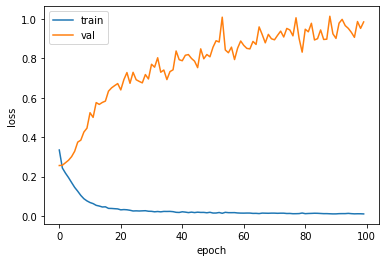

In [28]:
plt.plot(history_CNN_LSTM.history['loss'])
plt.plot(history_CNN_LSTM.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [29]:
model_CNN_LSTM.evaluate(val_x, val_y)

74/74 [==============================] - 0s 6ms/step - loss: 0.9855 - acc: 0.8774


[0.9855098128318787, 0.8773504495620728]

# 최종평가 : test set 예측 

In [35]:
def show_metrics(y_pred, y_actual) :
  print('Accuracy  :',  accuracy_score(y_pred, y_actual))
  print('Precision :', precision_score(y_pred, y_actual))
  print('Recall    :',    recall_score(y_pred, y_actual))
  print('F1-score  :',        f1_score(y_pred, y_actual))
  print('Auc       :',   roc_auc_score(y_pred, y_actual))

In [36]:
def show_confusion_matrix(y_pred, y_actual, path, model_name) :
  fig = plt.figure(figsize = (10, 8))
  plt.title(model_name + ' Confusion Matrix')
  sns.heatmap(confusion_matrix(y_pred, y_actual), annot = True, fmt = 'd', 
              cbar = False, cmap = sns.color_palette("Purples",2),
              xticklabels = ['Positive', 'Negative'],
              yticklabels = ['Positive', 'Negative'])
  plt.xlabel('Actuals')
  plt.ylabel('Predicted')
  plt.savefig(path + model_name +'_confusion_matrix.png', dpi = 300)
  plt.show()

In [37]:
model_LSTM.evaluate(test_x,test_y)

82/82 [==============================] - 1s 8ms/step - loss: 1.2414 - acc: 0.8838


[1.241439700126648, 0.8838461637496948]

In [38]:
y_pred = (model_CNN_LSTM.predict(test_x) > 0.5).astype("int32")
path2 = '/content/drive/MyDrive/ML2/'
model_CNN_LSTM.save(path2 + 'CNN_LSTM.h5')

82/82 [==============================] - 0s 6ms/step


Accuracy  : 0.8634615384615385
Precision : 0.8683812405446294
Recall    : 0.8638073739653875
F1-score  : 0.8660882685778951
Auc       : 0.8634536476435907


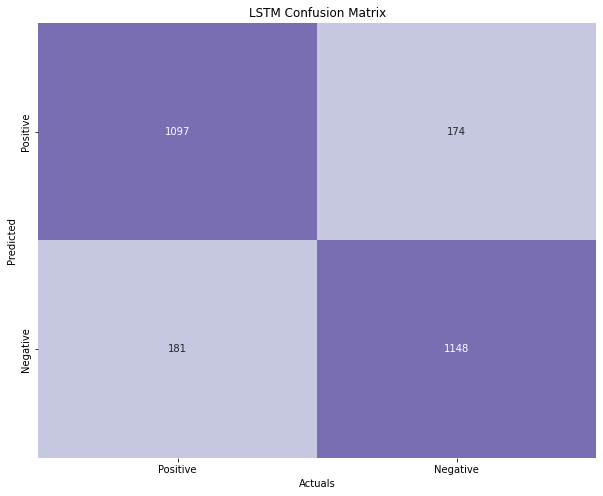

In [40]:
show_metrics(y_pred, test_y)
show_confusion_matrix(y_pred, test_y, path2, 'LSTM')